### BLS CES (Current Employment Statistics)

Uses flat files from the establishment survey from the monthly jobs report.

In [2]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

In [76]:
# Retrieve flat files from BLS
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/110.0'}

# Industry codes
url = 'https://download.bls.gov/pub/time.series/ce/ce.industry'
r = requests.get(url, headers=headers)
ind = pd.read_csv(io.StringIO(r.content.decode('utf-8')), sep='\t')
ind_g1 = ind[(ind['naics_code'].str.len() == 3)]
ind_g2 = ind[(ind['naics_code'].str.len() != 3) & 
             (ind['display_level'] == 4) & 
             (ind['publishing_status'] != 'C') &
             (ind['naics_code'] != '621,2,3') &
             (ind['naics_code'] != '-')]
ind_g3 = ind[(ind['naics_code'].str.len() == 2) & 
             (~ind['naics_code'].isin(ind_g1.naics_code.str[:2].unique()))]

indg = pd.concat([ind_g1, ind_g2, ind_g3])

# Series IDs
url2 = 'https://download.bls.gov/pub/time.series/ce/ce.series'
r2 = requests.get(url2, headers=headers)
converters = {'series_id        ': lambda x: x.strip()}
srs = pd.read_csv(io.StringIO(r2.content.decode('utf-8')), sep='\t', 
                  converters=converters)
srs.columns = srs.columns.str.strip()

# AHE and Payrolls for 3 digit industries, NSA
ind_grps = indg.merge(srs).query('data_type_code in [1, 3] and seasonal == "U"')

# Supersector
ss = {'90000000': 'Government',
      '06000000': 'Private Goods-Producing',
      '08000000': 'Private Service-Producing'}
ss = {f'CEU{k}01':v for k,v in ss.items()}

# Seleted other series
s_list = ['CEU0000000001', 'CES0000000001', 'CEU0500000006', 
          'CES0500000003', 'CES0500000008', 'CES9091000001',
          'CES9092000001', 'CES9093000001', 'CES0600000002',
          'CES9000000001', 'CES3000000008', 'CES1000000008', 
          'CES4422000008', 'CES4142000008', 'CES5000000008', 
          'CES5500000008', 'CES6000000008', 'CES6500000008', 
          'CES2000000008', 'CES7000000008', 'CES4300000008', 
          'CES4200000008', 'CEU0500000001', 'CES0500000006', 
          'CES0500000001', 'CES0000000001', 'CES3000000001', 
          'CES1000000001', 'CES4422000001', 'CES4142000001', 
          'CES5000000001', 'CES5500000001', 'CES6000000001', 
          'CES6500000001', 'CES0500000001', 'CES2000000001', 
          'CES7000000001', 'CES4300000001', 'CES4200000001'] + list(ss.keys())
others = srs[srs['series_id'].isin(s_list)]
sel = pd.concat([ind_grps, others])
sel.to_csv(data_dir / 'ces_meta_raw.csv')

In [77]:
# Full CES dataset
url3 = 'https://download.bls.gov/pub/time.series/ce/ce.data.0.AllCESSeries'
r3 = requests.get(url3, headers=headers)
converters = {'series_id        ': lambda x: x.strip()}
raw = pd.read_csv(io.StringIO(r3.content.decode('utf-8')), sep='\t', 
                  converters=converters)
raw.columns = raw.columns.str.strip()

# Annual data
sd = raw.query('series_id in @sel.series_id and year > 1987')
sdy = sd.query('period == "M13"').set_index(['year', 'series_id'])['value'].unstack()
sdy.index = pd.to_datetime(dict(year=sdy.index, month=7, day=1))
sdy.to_csv(data_dir / 'ces_ann_raw.csv', index_label='date')

#Monthly data
idx = ['year', 'period', 'series_id']
sdm = sd.query('period != "M13"').set_index(idx)['value'].unstack()
sdm.index = [pd.to_datetime(f'{year}-{period[1:]}-01') 
             for year, period in sdm.index]
sdm.to_csv(data_dir / 'ces_raw.csv', index_label='date')

### Job Growth by Sector

In [66]:
sdm = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                  parse_dates=True)
# Supersector
ss = {'90000000': 'Gov.',
      '06000000': 'Goods',
      '08000000': 'Services'}
ss = {f'CEU{k}01':v for k,v in ss.items()}
df = sdm[ss.keys()]
res = (df.iloc[-1] - 
       df.loc[pd.to_datetime(f'{2019}-{df.index[-1].month}-01')]).rename(ss)

# Bar plot
ssd = {'Gov.': 'green!85!yellow!75!black',
       'Goods': 'blue!80!black',
       'Services': 'cyan!80!white'}

bars = '\n'.join([f'\\addplot[{ssd[n]}]coordinates {{({i+1},{res[n]})}};' 
                  for i, n in enumerate(ssd.keys())])
write_txt(text_dir / 'emp_ss_bars.txt', bars)

ltdt = dtxt(sdm.index[-1])['mon1']
tot = value_text(res.sum() * 1_000, ptype=None, adj='total', digits=0)
gov = value_text(res['Gov.'] * 1_000, 'increase_by', ptype=None, 
                 digits=0, casual=True)
priv = value_text((res.sum() - res['Gov.']) * 1_000, ptype=None, 
                  adj='total', digits=0)
goods = value_text(res['Goods'] * 1_000, 'added_lost', ptype=None, 
                   digits=0)
serv = (value_text(res['Services'] / 1_000, 'added_lost', 
                   ptype=None, digits=1) + ' million')
if res.Services < 1_000:
    serv = value_text(res['Services'] * 1_000, 'added_lost', 
                      ptype=None, digits=0)
text = (f'Over the four years ending {ltdt}, nonfarm payrolls '+
        f'{tot}. By sector, combined government payrolls {gov} {c_box(ssd["Gov."])}, '+
        f'and private payrolls {priv} over the four-year period. Private '+
        f'goods-producing industries {goods} jobs {c_box(ssd["Goods"])}, and private service-'+
        f'providing industries {serv} jobs {c_box(ssd["Services"])}. ')
write_txt(text_dir / 'nfp_ss.txt', text)
print(text)

Over the four years ending August 2023, nonfarm payrolls increased by a total of 5,208,000. By sector, combined government payrolls grew by 106,000 (see \cbox{green!85!yellow!75!black}), and private payrolls increased by a total of 5,102,000 over the four-year period. Private goods-producing industries added 518,000 jobs (see \cbox{blue!80!black}), and private service-providing industries added 4.6 million jobs (see \cbox{cyan!80!white}). 


### Job Growth By 2019 Wage Tercile

In [67]:
sel = pd.read_csv(data_dir / 'ces_meta_raw.csv')
d = sel.set_index('series_id')['industry_name'].dropna().to_dict()

v19 = pd.read_csv(data_dir / 'ces_ann_raw.csv', index_col='date', 
                 parse_dates=True).loc['2019-07-01', d.keys()]

c = {'ahe': '3', 'emp': '1'}
df = pd.DataFrame({n: v19[v19.index.str.endswith(i)].rename(d) 
                   for n, i in c.items()})

# Latest data and four-year prior
lt = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                 parse_dates=True).iloc[[-1, -49]].T.loc[d.keys()]
df[['emplt', 'emppr']] = lt[lt.index.str.endswith('1')].rename(d)
df['diff'] = df['emplt'] - df['emppr']


# Split into three wage groups
dft = df.dropna()
df['cdf']  = dft.sort_values('ahe').emp.cumsum() / dft.emp.sum()
grps = (lambda x: np.where(x.cdf < (1/3), 'Lowest Third', 
                  np.where((x.cdf >= (1/3)) & (x.cdf < (2/3)), 'Middle Third', 
                  np.where((x.cdf >= (2/3)) & (x.cdf <= 1), 'Highest Third', 'none'))))

df = df.assign(grps = grps)

res = df.groupby('grps')['diff'].sum().drop('none').round()

(res.to_csv(data_dir / 'jobs_tercile.csv', index_label='grps', 
            header=True))

# Footer for industries missing wage data
nonech = value_text(df.groupby('grps')['diff'].sum()['none'] * 1_000, 
                    'added_lost', ptype=None, digits=0)
text = (f'Private industries without wage information {nonech} '+
        'jobs over the period.')
write_txt(text_dir / 'jobs_nowage_ch.txt', text)
emp3dt = f"{dtxt(sdm.index[-49])['mon1']} to {dtxt(sdm.index[-1])['mon1']}"
write_txt(text_dir / 'emp_3_dates.txt', emp3dt)

# Text
low = value_text(res['Lowest Third'] * 1000, 'added_lost', ptype=None, digits=0)
mid = value_text(res['Middle Third'] * 1000, 'added_lost', ptype=None, 
                 digits=0, casual=True)
high = (value_text(res['Highest Third'] / 1000, 'added_lost', ptype=None, 
                   digits=2) + ' million')
if res['Highest Third'] < 1000:
    high = value_text(res['Highest Third'] * 1000, 'added_lost', 
                      ptype=None, digits=0)
prdt = dtxt(lt.columns[1])['mon1']
text = ('Dividing the private industries into three wage groups, the '+
        f'lowest-wage industries {low} jobs since {prdt}, the middle-wage '+
        f'industries {mid} jobs, and the highest-wage industries {high} '+
        f'jobs {c_box("violet!70!magenta")}. ')
write_txt(text_dir / 'nfp_wg.txt', text)
print(text)

Dividing the private industries into three wage groups, the lowest-wage industries added 1,207,000 jobs since August 2019, the middle-wage industries gained 569,000 jobs, and the highest-wage industries added 3.11 million jobs (see \cbox{violet!70!magenta}). 


### Overview Jobs Growth and Monthly Change

In [68]:
sl = {'CEU0000000001': 'NFP', 'CES0000000001': 'NFPsa', 
      'CEU0500000006': 'PNS', 'CES0500000006': 'PNSsa',
      'CEU0500000001': 'PNFP', 'CES0500000001': 'PNFPsa'}
# CES series from flat/text files
df = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                 parse_dates=True).loc[:, sl.keys()].rename(sl, axis=1)
# Add LFS series from jobs report
df[['EMP', 'EMPsa']] = (pd.read_csv(data_dir / 'jobs_report_main2.csv', 
                                   index_col='date', parse_dates=True)
                          .loc[:, ['EMP', 'EMPsa']])
# Save results for time series graph
res = df.loc['1989':].divide(1000)
res.to_csv(data_dir / 'emp_ts.csv', index_label='date')

# End nodes for time series graph
res2 = res[['NFP', 'EMP', 'PNS']]
adj = node_adj(res2)
smax = res2.iloc[-1].idxmax()
adj[smax] = adj[smax] + 0.35
cols = {'NFP': 'blue!70!white', 'EMP': 'magenta',
        'PNS': 'orange!80!yellow'}
date = {series: 'm' if series in ['EMP'] else None 
        for series in cols.keys()}
nodes  ='\n'.join([end_node(res2[series].dropna(), color, date=date[series], 
                            full_year=True, size=1.1, offset=adj[series]) 
                   for series, color in cols.items()])
write_txt(text_dir / 'emp_ts_nodes.txt', nodes) 

# Latest values bar graph
sa = df[['NFPsa', 'EMPsa']]
final2 = sa.diff().loc['2019'].mean().to_frame().T
final2['label'] = '2019 Average'
final = sa.diff().iloc[-3:]
final['label'] = [dtxt(i)['mon2'] for i in final.index]
final = pd.concat([final2, final])
final.to_csv(data_dir / 'emp_lt.csv', index_label='date')

In [69]:
ltdt = dtxt(res.index[-1])['mon1']
lt = res.iloc[-1]
pc = res.loc[:'2020-03-01']
pnssh = (lt.PNS / lt.PNFP) * 100

cl = {n: c_line(col) for n, col in cols.items()}
text = (f'In {ltdt}, establishments report {lt.NFP:.1f} million '+
        f'\\textbf{{nonfarm payroll employees}} {cl["NFP"]}. '+
        f'The pre-COVID peak was {pc.NFP.max():.1f} million '+
        f'in {dtxt(pc.NFP.idxmax())["mon1"]}. '+
        f'Households report {lt.EMP:.1f} million employed '+
        'people, including the self-employed but not including '+
        'armed forces, in the latest month, compared to a pre-COVID '+
        f'peak of {pc.EMP.max():.1f} million {cl["EMP"]}. \n\nPrivate '+
        'production and nonsupervisory workers are engaged in '+
        'production, including working supervisors, or in other '+
        'activities but not above the working supervisor level. '+
        f'In {ltdt}, this group totals {lt.PNS:.1f} million, compared '+
        f'to a pre-COVID peak of {pc.PNS.max():.1f} million {cl["PNS"]}. '+
        f'Production and nonsupervisory workers comprise {pnssh:.1f} '+
        f'percent of private nonfarm payrolls in {ltdt}. ')
write_txt(text_dir / 'emp_overview1.txt', text)
print(text)

lc = res.diff().iloc[-1] * 1_000_000
ltemp = value_text(lc.EMPsa, 'increase_by', ptype=None, digits=0)
a19 = res.diff().loc['2019'].mean() * 1_000_000
empc = compare_text(lc.EMPsa, a19.EMPsa, [30000, 50000, 150000])
nfpal = 'added' if lc.NFPsa >= 0 else 'lost'
a3m = value_text(round(res[['NFPsa', 'EMPsa']].diff().iloc[-3:].mean().mean()
                       * 1_000_000, -2), 
                 'increase_of', ptype=None, digits=0)
text = (f'In {ltdt}, seasonally-adjusted civilian employment {ltemp} '+
        f'{c_box(cols["EMP"])}, {empc} the 2019 average increase of '+
        f'{a19.EMPsa:,.0f} jobs per month. The US {nfpal} a net total '+
        f'of {lc.NFPsa:,.0f} nonfarm payroll jobs in {ltdt} '+
        f'{c_box(cols["NFP"])}, compared to a monthly average of '+
        f'{a19.NFPsa:,.0f} in 2019. The average of both surveys over '+
        f'the past three months shows {a3m} employees per month.  ')
write_txt(text_dir / 'emp_overview2.txt', text)
print('\n', text)

In August 2023, establishments report 156.3 million \textbf{nonfarm payroll employees} (see {\color{blue!70!white}\textbf{---}}). The pre-COVID peak was 153.1 million in November 2019. Households report 161.4 million employed people, including the self-employed but not including armed forces, in the latest month, compared to a pre-COVID peak of 159.1 million (see {\color{magenta}\textbf{---}}). 

Private production and nonsupervisory workers are engaged in production, including working supervisors, or in other activities but not above the working supervisor level. In August 2023, this group totals 109.5 million, compared to a pre-COVID peak of 106.9 million (see {\color{orange!80!yellow}\textbf{---}}). Production and nonsupervisory workers comprise 81.4 percent of private nonfarm payrolls in August 2023. 

 In August 2023, seasonally-adjusted civilian employment increased by 222,000 (see \cbox{magenta}), substantially above the 2019 average increase of 168,083 jobs per month. The US ad

In [70]:
d = {'EMP': 'Employed', 'NFP': 'Nonfarm Payrolls',
     'PNFP': '\hspace{1mm} Private Nonfarm Payrolls',
     'PNS': '\hspace{2mm} Production \& Nonsuperv.'}
d = {**{f'{k}sa': v for k,v in d.items()}, **d}

g1 = ['EMP', 'NFP', 'PNFP', 'PNS']
g2 = [f'{i}sa' for i in g1]

r2 = res.copy()
r2.index = [dtxt(i)['mon2'] for i in r2.index]

tbl = pd.concat([r2[g2].iloc[-2:].T.iloc[:, ::-1].rename(d), 
                 r2[g1].iloc[-2:].T.iloc[:, ::-1].rename(d)], axis=1)
tbl['2019 Avg.'] = res.loc['2019', g1].mean().rename(d)
tbl['2017 Avg.'] = res.loc['2017', g1].mean().rename(d)
tbl['2000 Avg.'] = res.loc['2000', g1].mean().rename(d)

tbl.applymap('{:.1f}'.format).to_csv(data_dir/'emp_overview.tex', sep='&', 
             lineterminator='\\\ ', quotechar=' ')

### Payrolls by Industry Summary Table

In [71]:
s = {'CEU0000000001': 'Total nonfarm',
     'CEU0500000001': '\hspace{1mm} Total private',
     'CEU0600000001': '\hspace{2mm} Goods-producing',
     'CEU1000000001': '\hspace{4mm} Mining \& logging',
     'CEU2000000001': '\hspace{4mm} Construction',
     'CEU3000000001': '\hspace{4mm} Manufacturing',
     'CEU0800000001': '\hspace{2mm} Private service-providing',
     'CEU4142000001': '\hspace{4mm} Wholesale trade',
     'CEU4200000001': '\hspace{4mm} Retail trade',
     'CEU4300000001': '\hspace{4mm} Transportation \& warehousing',
     'CEU5000000001': '\hspace{4mm} Information',
     'CEU5500000001': '\hspace{4mm} Financial activities',
     'CEU5553000001': '\hspace{4mm} Real estate \& rental \& leasing',
     'CEU6054000001': '\hspace{4mm} Professional \& technical services',
     'CEU6055000001': '\hspace{4mm} Management',
     'CEU6056100001': '\hspace{4mm} Administrative \& support',
     'CEU6561000001': '\hspace{4mm} Educational services',
     'CEU6562000101': '\hspace{4mm} Health care',
     'CEU6562400001': '\hspace{4mm} Social assistance',
     'CEU7071000001': '\hspace{4mm} Arts, entertainment, \& recreation',
     'CEU7072100001': '\hspace{4mm} Accommodation',
     'CEU7072200001': '\hspace{4mm} Food services \& drinking places',
     'CEU8000000001': '\hspace{4mm} Other services',
     'FromData': '\hspace{4mm} Utilities and waste management',
     'CEU9000000001': '\hspace{1mm} Government'}
s_other = ['CEU4422000001', 'CEU6056200001']

In [72]:
# Not seasonally adjusted data
res = raw.query('(series_id in @s.keys() or series_id in @s_other) '+
                'and year > 1988 and period != "M13"')
res = res.set_index(['year', 'period', 'series_id'])['value'].unstack()
res.index = [pd.to_datetime(f'{year}-{period[1:]}-01') 
             for year, period in res.index]
res[s['FromData']] = res[s_other].sum(axis=1)
res = res.drop(s_other, axis=1)
res = res.rename(s, axis=1)
tbl = pd.DataFrame({ltdt: res.iloc[-1], 
                    '4-year change': res.diff(48).iloc[-1]}).loc[s.values()]
# Seasonally adjusted data
s2 = {k.replace('CEU', 'CES'): v for k,v in s.items()}
s2_other = [i.replace('CEU', 'CES') for i in s_other]
res2 = raw.query('(series_id in @s2.keys() or series_id in @s2_other) '+
                'and year > 1988 and period != "M13"')
res2 = res2.set_index(['year', 'period', 'series_id'])['value'].unstack()
res2.index = [pd.to_datetime(f'{year}-{period[1:]}-01') 
             for year, period in res2.index]
res2[s['FromData']] = res2[s2_other].sum(axis=1)
res2 = res2.drop(s2_other, axis=1)
res2 = res2.rename(s2, axis=1)
ltdr = f"{dtxt(res2.index[-3])['mon6']}-- {dtxt(res2.index[-1])['mon6']} average"
prdr = f"{dtxt(res2.index[-6])['mon6']}-- {dtxt(res2.index[-4])['mon6']} average"
tbl2 = pd.DataFrame({f'{ltdt} ': res2.iloc[-1], 
                     '1-month change': res2.diff().iloc[-1],
                     ltdr: res2.diff().iloc[-3:].mean(),
                     prdr: res2.diff().iloc[-6:-3].mean()}).loc[s2.values()]
table = tbl2.join(tbl).applymap('{:,.0f}'.format).replace('-0', '0')
table.index.name = ''
table.to_csv(data_dir/'nfp.tex', sep='&', 
             lineterminator='\\\ ', quotechar=' ')

In [73]:
st = res.diff(48).iloc[-1].sort_values()
st.index = [i.split('} ')[-1].replace('\&', 'and').lower() 
            for i in st.index]
excats = ['government', 'other services', 'total nonfarm', 
          'total private', 'private service-providing', 
          'goods-producing']
st = (st.multiply(1000).apply('{:+,.0f}'.format)
        .drop(excats))

ltdt = dtxt(res.index[-1])['mon1']
high = [f'{st.index[i]} ({st.iloc[i]})' for i in [-1, -2, -3, -4]]
htxt = ', and '.join([', '.join(high[:3]), high[3]])
low = [f'{st.index[i]} ({st.iloc[i]})' for i in [0, 1, 2]]
ltxt = ', and '.join([', '.join(low[:2]), low[2]])

text = (f'Over the four years ending {ltdt}, the industry '+
        'groups with the largest increase in payrolls were '+
        f'{htxt}. The private industry groups with the least '+
        f'least job growth were {ltxt}.')
write_txt(text_dir / 'emp_ind.txt', text)
print(text)

Over the four years ending August 2023, the industry groups with the largest increase in payrolls were professional and technical services (+1,359,200), transportation and warehousing (+949,200), health care (+683,400), and construction (+441,000). The private industry groups with the least least job growth were accommodation (-233,900), mining and logging (-83,000), and arts, entertainment, and recreation (+22,100).


### Gross Labor Income

In [ ]:
# Calculate GLI
start = '2017-01-01'
emp = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                 parse_dates=True)['CEU0000000001'].pct_change(12) * 100
ahe = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date',  
                  parse_dates=True)['CES0500000003'].pct_change(12) * 100
nfp = (emp + ahe).rename('NFP').dropna()
nfp.loc[start:].to_csv(data_dir / 'gli_nfp.csv', index_label='date')

# Horizontal bar at 5
end = dtxt(nfp.index[-1] + pd.DateOffset(months=1))['datetime']
hbar = (f'\draw [dotted, thick] (axis cs:{{{start}}}, 5) -- '+
        f'(axis cs:{{{end}}}, 5);')
write_txt(text_dir / 'gli_hbar.txt', hbar) 

# Text
cline = c_line('blue!55!purple!50!white')
ltdt = dtxt(nfp.index[-1])['mon1']
prdt = dtxt(nfp.index[-13])['mon1']
text = (f'Using the nonfarm payrolls approach {cline}, the one-year '+
        f'growth rate of gross labor income is {nfp.iloc[-1]:.1f} '+
        f'percent in {ltdt}, following {nfp.iloc[-13]:.1f} percent '+
        f'one-year prior, in {prdt}.')
write_txt(text_dir / 'gli_nfp.txt', text)
print(text)

### Government Jobs
The jobs report doesn't include the full population, which is provided by Census

In [ ]:
pop = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                  parse_dates=True)['B230RC'])
popest = pd.read_csv(data_dir/'pop_est_bea.csv', index_col='date', 
                     parse_dates=True) / 1000

data = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                  parse_dates=True)

jobcats = {'CES9000000001': 'govjobs',
           'CES9091000001': 'fedjobs',
           'CES9092000001': 'stjobs',
           'CES9093000001': 'locjobs'}
df = data.rename(jobcats, axis=1)[jobcats.values()]

# Fill missing population date from Census
if df.index[-1] > pop.index[-1]:
    pop[df.index[-1]] = popest.loc[df.index[-1], 'POP']
    
# Share of population    
sh = df.divide(pop, axis=0) * 100
sh.loc['1989':].to_csv(data_dir / 'govjobs.csv', index_label='date')
grps = {'govjobs': 'blue!50!cyan', 'fedjobs': 'green!80!blue',
        'stjobs': 'orange', 'locjobs': 'red'}
for cat, col in grps.items():
    node = (end_node(sh[cat], col, date='m') 
            if cat == 'govjobs' 
            else end_node(sh[cat], col))
    write_txt(text_dir / f'{cat}_node.txt', node)
    
ltdate = dtxt(sh.index[-1])['mon1']
pryrdate = dtxt(sh.index[-13])['mon1']
ltval = df.govjobs.iloc[-1] / 1000 
pryrval = df.govjobs.iloc[-13] / 1000 
ltsh = sh.govjobs.iloc[-1]
pryrsh = sh.govjobs.iloc[-13]
ltfed = df.fedjobs.iloc[-1] / 1000 
ltst = df.stjobs.iloc[-1] / 1000 
ltloc = df.locjobs.iloc[-1] / 1000 
ltfedsh = sh.fedjobs.iloc[-1] 
ltstsh = sh.stjobs.iloc[-1]
ltlocsh = sh.locjobs.iloc[-1]
diff = df.govjobs.iloc[-1] - df.govjobs.loc['2019-12-01']#.mean()
gl = 'gained' if diff > 0 else 'lost'
difftxt = (f'{gl} {abs(diff):.0f},000' if abs(diff) < 1000 
           else f'{gl} {abs(diff) / 1000:.1f} million')
txt3 = f'Since 2019, the US has {difftxt} total government jobs. '
sh90 = sh.loc['1990':'1999', 'govjobs'].mean()
diff90 = ((sh90 / 100)
          * pop.iloc[-1]) - df.govjobs.iloc[-1]

txt1 = (f'In {ltdate}, there were {ltval:.1f} million government jobs, '+
        f'equivalent to {ltsh:.1f} for every 100 people '+
        f'(see {{\color{{{grps["govjobs"]}}}\\textbf{{---}}}}). The previous year, '+
        f'in {pryrdate}, there were {pryrval:.1f} million government jobs, '+
        f'equivalent to {pryrsh:.1f} per 100 people. '+
        f'During the 1990s, there were {sh90:.1f} government jobs per 100 people. '+
        'If the rate was the same today, there would be '+
        f'{diff90 / 1_000:.1f} million additional government jobs.'+
        f'\n\nBy level of government, there were {ltloc:.1f} million '+
        f'local government jobs in {ltdate}, equivalent to '+
        f'{ltlocsh:.1f} per 100 people '+
        f'(see {{\color{{{grps["locjobs"]}}}\\textbf{{---}}}}). '+
        f'In the same period, there were {ltst:.1f} million state '+
        f'government job ({ltstsh:.1f} per 100 people, '+
        f'see {{\color{{{grps["stjobs"]}}}\\textbf{{---}}}}), and '+
        f'{ltfed:.1f} million federal government job ({ltfedsh:.1f} '+
        f'per 100 people, see {{\color{{{grps["fedjobs"]}}}\\textbf{{---}}}}).')

ch19 = df.iloc[-1] - df.loc['2019-12-01']#.mean()
locchsh = (ch19.locjobs / ch19.govjobs) * 100
stchtxt = value_text(ch19.stjobs, style='added_lost', ptype=None, digits=0)
fedchtxt = value_text(ch19.fedjobs, style='added_lost', ptype=None, digits=0)
locchtxt = value_text(ch19.locjobs, style='added_lost', ptype=None, digits=0)
aw = 'and' if ch19.fedjobs < 0 else 'while'
if (ch19.govjobs < 0) and (ch19.locjobs < 0):
    txt = (f'Of these, {abs(ch19.locjobs):,.0f},000, or {locchsh:.1f} '+
           'percent of the shortfall, are local government jobs. '+
           'During the same period, ')
else:
    txt = f'During the same period, local governments {locchtxt},000 jobs, '
    
txt2 = (f'state governments {stchtxt},000 jobs, {aw} '+
        f'the federal government {fedchtxt},000 jobs.')
text = txt1 + '\n\n' + txt3 + txt + txt2
write_txt(text_dir / 'govjobs.txt', text)
print(text)

### Average Hourly Earnings

From CES Flat File

In [ ]:
# Average hourly earnings recent monthly change
s = {'CES0500000003': 'ALL', 'CES0500000008': 'PNS'}
# CES series from flat/text files
df = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                 parse_dates=True)[s.keys()].rename(s, axis=1)
data = (df.pct_change(12) * 100)
d3 = m3rate(df).rename({'ALL': 'ALL_3M', 'PNS': 'PNS_3M'}, axis=1)
data = data.join(d3).loc['1989':]
data.to_csv(data_dir / 'ahe.csv', index_label='date', 
            float_format='%g')
ltdt = dtxt(data.index[-1])['mon1']
lt = data.iloc[-1]
all_lt = value_text(lt.ALL, style='increase_by')
pns_lt = value_text(lt.PNS, style='increase_by')
all_3m = value_text(lt.ALL_3M, style='increase_by', adj='annual')
pns_3m = value_text(lt.PNS_3M, style='increase_by', adj='annual')
cla = c_line('magenta')
clp = c_line('blue!80!black')
text = (f'Over the year ending {ltdt}, \\textbf{{average hourly earnings}} '+
        f'{all_lt} for all employees {cla} and {pns_lt} for production '+
        f'and non-supervisory workers {clp}, according to the '+
        'Bureau of Labor Statistics. Comparing the latest '+
        f'three months to the previous three months, average earnings '+
        f'{all_3m} for all employees and {pns_3m} for production '+
        'and non-supervisory employees.')
write_txt(text_dir / 'ahe_summary.txt', text)
print(text)

### AHE by Industry

In [ ]:
s = {'CES3000000008': 'Manufacturing',
     'CES1000000008': 'Mining \& Logging',
     'CES4422000008': 'Utilities',
     'CES4142000008': 'Wholesale Trade',
     'CES5000000008': 'Information',
     'CES5500000008': 'Financial Activities',
     'CES6000000008': 'Professional \& Business Services',
     'CES6500000008': 'Education \& Health Services',
     'CES0500000008': 'Total Private',
     'CES2000000008': 'Construction',
     'CES7000000008': 'Leisure \& Hospitality',
     'CES4300000008': 'Transportation \& Warehousing',
     'CES4200000008': 'Retail Trade'}

data = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                   parse_dates=True)[s.keys()].rename(s, axis=1)
df = data.loc['2017':]
df.to_csv(data_dir / 'ahe_industry_raw.csv', index_label='date')

In [ ]:
p = pd.read_csv(data_dir / 'cpi.csv')
df = (pd.read_csv(data_dir / 'ahe_industry_raw.csv', parse_dates=['date'])
        .set_index('date'))
allitems = p['ALL'].iloc[-1]
data = (df.pct_change(12).iloc[-1] * 100.0).sort_values(ascending=False)

data.to_csv(data_dir / 'ahe_ind.csv', index_label='name', header=True)

write_txt(text_dir / 'ahe_bar_date.txt', df.index[-1].strftime('%B %Y'))

real = (data - allitems).drop('Total Private')
ltd = {i: (data.index[i].lower(), data.iloc[i]) for i in [0, 1, 2]}
rwn = len(real.loc[real > 0])
rwg = numbers2[rwn] if rwn < 10 else rwn
if rwn == 0:
    rwg = 'none'
alltxt = 'all ' if rwg == 12 else ''

txt1 = (f'By industry, {alltxt}{rwg} of the {len(real)} groups '+
         'experienced real wage growth (wage growth above the increase in '+
        f'prices indicated by the consumer price index). The {ltd[0][0]} '+
        f'industry had the fastest nominal growth rate, at {ltd[0][1]:.1f} '+
        f'percent, followed by {ltd[1][1]:.1f} percent in {ltd[1][0]} and '+
        f'{ltd[2][1]:.1f} percent in {ltd[2][0]}. ')
write_txt(text_dir / 'ahe_comp.txt', txt1)
print(txt1)

### Nonfarm Payrolls

In [8]:
df = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                   parse_dates=True).loc['2015':, 'CES0000000001']

pop = pd.read_csv(data_dir / 'jobs_report_main.csv', 
                  index_col='date', parse_dates=True).loc['2015':, 'POP']

data = df.diff().loc['2019':] * 1_000
data.name = 'ALL'
data.div(1_000_000).to_csv(data_dir / 'nfp.csv', index_label='date')

ltdt = dtxt(data.index[-1])['mon1']
prdt = dtxt(data.index[-2])['mon1']
if prdt[-4:] == ltdt[-4:]:
    prdt = prdt[:-5]
pr2dt = dtxt(data.index[-3])['mon1']
if pr2dt[-4:] == ltdt[-4:]:
    pr2dt = pr2dt[:-5]
lt = value_text(data.iloc[-1], 'increase_by', ptype=None, digits=0)
al = 'added' if data.iloc[-2] >= 0 else 'lost'
pr = f'{data.iloc[-2]:,.0f} jobs {al}'
pr2 = value_text(data.iloc[-3], 'added_lost_rev', ptype=None, 
                 digits=0)
cb = c_box('blue!60!purple')
val3m = data.iloc[-3:].mean()
valpr3m = data.iloc[-6:-3].mean()
ct = compare_text(val3m, valpr3m, [50000, 150000, 500000])
cov = data.loc['2020-03-01':'2020-04-01'].sum() / 1_000_000
pcadd = data.loc['2020-05-01':].sum() / 1_000_000
pcsh = (pcadd / abs(cov)) * 100
lpop = (pop.diff().rolling(12).mean().iloc[-1] * 
        (df / pop).rolling(12).mean().iloc[-1]) * 1_000
pr19v = data.loc['2019'].mean().round(-2)
pr3yr = value_text(data.iloc[-48:].mean().round(-2), 'added_lost', 
                   ptype=None, digits=0, adj='average')

text = (f'Nonfarm payrolls {lt} in {ltdt}, following {pr} in {prdt}, '+
        f'and {pr2} in {pr2dt} {cb}. Average payroll growth was '+
        f'{round(val3m,-2):,.0f} over these three months, '+
        f'{ct} the average of {round(valpr3m,-2):,.0f} '+
        'during the previous three months. \n\n During March and '+
        f'April 2020, the US lost a combined {abs(cov):.0f} million '+
        f'jobs. Since May 2020, a total of {pcadd:.1f} million jobs '+
        f'have been added, equivalent to {pcsh:.1f} percent of those lost.\n\n'+
        'To maintain a steady payroll employment rate with population growth, '+
        f'the US needed to add {round(lpop, -3):,.0f} '+
        f'jobs in {ltdt}. Pre-pandemic, in 2019, the US was adding an average '+
        f'of {pr19v:,.0f} jobs per month.')
write_txt(text_dir / 'nfp_basic_text.txt', text)
print(text)

# Node for latest value
tloc = dtxt(data.index[-1] - pd.DateOffset(weeks=26))['datetime']
tdt = dtxt(data.index[-1])['mon6']
pm = '+' if data.iloc[-1] >= 0 else '-'
tv = f'{pm}{abs(data.iloc[-1] / 1_000):.0f}k'
if abs(data.iloc[-1]) > 994_000:
    tv = f'{pm}{abs(data.iloc[-1] / 1_000_000):.1f} million'
text = ('\\node[below, align=right, pin=45:{}] at (axis cs: '+
        f'{{{tloc}}}, -1.2) {{\scriptsize {tdt}\\\\ \scriptsize {tv}}};')
write_txt(text_dir / 'nfp_lt_val.txt', text)

Nonfarm payrolls increased by 187,000 in August 2023, following 157,000 jobs added in July, and 105,000 added in June (see \cbox{blue!60!purple}). Average payroll growth was 149,700 over these three months, slightly below the average of 238,300 during the previous three months. 

 During March and April 2020, the US lost a combined 22 million jobs. Since May 2020, a total of 26.0 million jobs have been added, equivalent to 118.4 percent of those lost.

To maintain a steady payroll employment rate with population growth, the US needed to add 147,000 jobs in August 2023. Pre-pandemic, in 2019, the US was adding an average of 163,200 jobs per month.


### Recent values in detail

### AHE Monthly Change

In [74]:
# Average hourly earnings recent monthly change
s = {'CES0500000003': 'ALL', 'CES0500000008': 'PNS'}
# CES series from flat/text files
df = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                 parse_dates=True)[s.keys()].rename(s, axis=1)
res = (df.pct_change() * 100).dropna(how='all')
#res['FILL'] = 0
res['label'] = [dt.strftime('%b\\\%Y') if dt.month == 1 
                else dt.strftime('%b') if dt.month in [4, 7, 10]
                else '' for dt in res.index]

# Axis from CPI chart
cpi = pd.read_csv(data_dir / 'cpi_monthly.csv', index_col='date', 
                  parse_dates=True)

d = (pd.concat([cpi[['ALL_S', 'FILL']], res.iloc[-20:]], axis=1)
       .dropna(subset=['FILL']))
d['REAL'] = d['ALL'] - d['ALL_S']

d.to_csv(data_dir / 'ahe_monthly.csv', index_label='date', float_format='%g')

### Nonfarm Payrolls

In [ ]:
# Nonfarm payrolls
s = {'CES0000000001': 'NFP'}
# CES series from flat/text files
df = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                 parse_dates=True)[s.keys()].rename(s, axis=1)
res = df.diff()
res['label'] = [dt.strftime('%b\\\%Y') if dt.month == 1 
                else dt.strftime('%b') if dt.month in [4, 7, 10]
                else '' for dt in res.index]

# Axis from CPI chart
cpi = pd.read_csv(data_dir / 'cpi_monthly.csv', index_col='date', 
                  parse_dates=True)

d = (pd.concat([cpi[['ALL_S', 'FILL']], res.iloc[-20:]], axis=1)
       .dropna(subset=['FILL']))

d.to_csv(data_dir / 'nfp_monthly.csv', index_label='date', float_format='%g')

In [42]:
node = end_node(d['ALL'].dropna(), 'violet', size=0)

In [43]:
print(node)

\node[label={[yshift=0cm, xshift=0cm, align=left]0:{\scriptsize 0.4}}, circle, violet, fill, inner sep=0pt] at (axis cs:2023-07-01, 0.4166666666666652) {};


In [36]:
d

,ALL_S,FILL,ALL,PNS,label,REAL
date,,,,,,
2022-01-01,0.609498,0.0,0.668364,0.448430,Jan\\2022,0.058866
2022-02-01,0.711609,0.0,0.000000,0.372024,,-0.711609
2022-03-01,1.005587,0.0,0.632311,0.518903,,-0.373275
2022-04-01,0.396213,0.0,0.345586,0.553097,Apr,-0.050627
2022-05-01,0.920616,0.0,0.375704,0.440044,,-0.544912
2022-06-01,1.187909,0.0,0.374298,0.511135,,-0.813611
2022-07-01,-0.033930,0.0,0.466128,0.399564,Jul,0.500058
2022-08-01,0.234872,0.0,0.309310,0.397974,,0.074438
2022-09-01,0.412773,0.0,0.308356,0.360360,,-0.104416


In [44]:
d.REAL.dropna().iloc[-1].round(1)

0.2

In [34]:
d['REAL'] = d['ALL'] - d['ALL_S']

In [16]:
res.iloc[-20:].to_csv(data_dir / 'ahe_monthly.csv', 
                      index_label='date', float_format='%g')

In [ ]:
d = pd.concat([cpi['FILL'], res.iloc[-20:]], axis=1)

In [13]:
res['FILL'] = 0

In [19]:
cpi = pd.read_csv(data_dir / 'cpi_monthly.csv', index_col='date', 
                  parse_dates=True)

In [22]:
pd.concat([cpi['FILL'], res.iloc[-20:]], axis=1)

,FILL,ALL,PNS,FILL,label
date,,,,,
2021-12-01,NaN,0.576184,0.715092,0.0,
2022-01-01,0.0,0.668364,0.448430,0.0,Jan\\2022
2022-02-01,0.0,0.000000,0.372024,0.0,
2022-03-01,0.0,0.632311,0.518903,0.0,
2022-04-01,0.0,0.345586,0.553097,0.0,Apr
2022-05-01,0.0,0.375704,0.440044,0.0,
2022-06-01,0.0,0.374298,0.511135,0.0,
2022-07-01,0.0,0.466128,0.399564,0.0,Jul
2022-08-01,0.0,0.309310,0.397974,0.0,


<AxesSubplot: xlabel='date'>

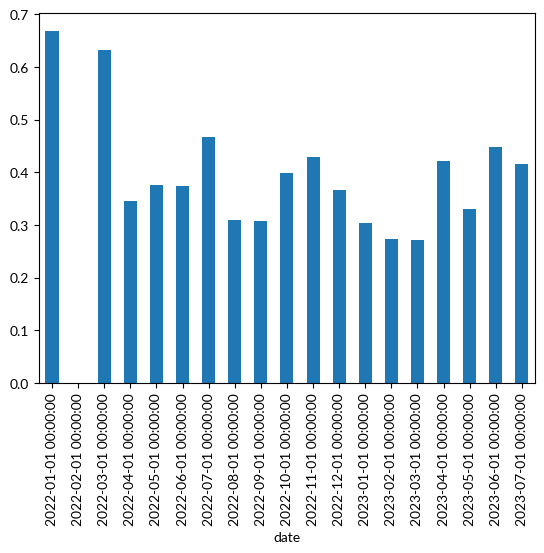

In [7]:
res = (df.pct_change() * 100).iloc[-20:]

In [49]:
# Nonfarm payrolls
s = {'CES0000000001': 'NFP'}
# CES series from flat/text files
df = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                 parse_dates=True)[s.keys()].rename(s, axis=1)
res = df.diff()
res['label'] = [dt.strftime('%b\\\%Y') if dt.month == 1 
                else dt.strftime('%b') if dt.month in [4, 7, 10]
                else '' for dt in res.index]

# Axis from CPI chart
cpi = pd.read_csv(data_dir / 'cpi_monthly.csv', index_col='date', 
                  parse_dates=True)

d = (pd.concat([cpi[['ALL_S', 'FILL']], res.iloc[-20:]], axis=1)
       .dropna(subset=['FILL']))

d.to_csv(data_dir / 'nfp_monthly.csv', index_label='date', float_format='%g')

In [50]:
d

,ALL_S,FILL,NFP,label
date,,,,
2022-01-01,0.609498,0.0,364.0,Jan\\2022
2022-02-01,0.711609,0.0,904.0,
2022-03-01,1.005587,0.0,414.0,
2022-04-01,0.396213,0.0,254.0,Apr
2022-05-01,0.920616,0.0,364.0,
2022-06-01,1.187909,0.0,370.0,
2022-07-01,-0.033930,0.0,568.0,Jul
2022-08-01,0.234872,0.0,352.0,
2022-09-01,0.412773,0.0,350.0,


In [47]:
df.diff()

,NFP
date,
1988-01-01,NaN
1988-02-01,461.0
1988-03-01,275.0
1988-04-01,243.0
1988-05-01,230.0
...,...
2023-03-01,217.0
2023-04-01,217.0
2023-05-01,281.0


In [ ]:
CES0000000001